# Lemke Howson: An algorithm to find Nash Equilibrium

This notebook introduces Lemke Howson algorithm for finding Nash equilibrium of a two-player normal form game. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Two-Player Games in Normal Form

We are going to find Nash equilibria (pure or mixed action) of a Two-Player Game $g = (I, (A_i)_{i \in I}, (u_i)_{i \in I})$, where 

* $I = \{0, 1\}$ is the set of players,
* $M = \{0, ..., m-1\}, N = \{m, ..., m+n-1\}$ are the action spaces,
* $\Delta^L = \{x \in \mathbb{R}^L_+ \mid \sum_{l \in L} x_l = 1\}, L=M, N$ are the mixed action spaces.
* $A \in \mathbb{R}^{M \times N}, B \in \mathbb{R}^{N \times M}$ are the payoff matrixs for player 0 and 1, respectively, and similarly the expected payoffs are $x^{\prime}Ay$ and $y^{\prime}Bx$.

### Nash Equilibrium

For $x \in \Delta^M$ and $y \in \Delta^N$, we define

$$
\bar{x} = \underset{j \in N}{\arg \max}(B x)_j, \quad 
x^\circ = \{i \in M \mid x_i = 0\} \\
\bar{y} = \underset{i \in M}{\arg \max}(A y)_i, \quad
y^\circ = \{j \in N \mid y_j = 0\} \\
\text{supp}(x) = \{i \mid x_i > 0\}, \quad 
\text{supp}(y) = \{j \mid y_j > 0\}
$$

According to von Stengel, B. (2007), we can judge whether $(x, y) \in \Delta^M \times \Delta^N$ is a Nash equilibrium by checking:

* $\text{supp}(x) \subset \bar{y}, \text{supp}(y) \subset \bar{x}$, or
* $\bar{y} \cup x^\circ = M, \bar{x} \cup y^\circ = N$, equivalently $(\bar{x} \cup x^\circ) \cup (\bar{y} \cup y^\circ) = M \cup N$.

These two conditions are equivalent, therefore checking one is enough to find a Nash equilibrium.

Depending on these two conditions, we may use some algorithms to compute Nash equilibrium of any well-defined two-player normal form game. However, we have to deal with some difficulties when facing degenerate games, as we will see later.

We first consider the case of nondegenerate game, which is simpler.

# Nondegenerate game

** Definition: ** A two-player game is nondegenerate if for any $x \in \Delta^M$ and any $y \in \Delta^N$, we have

$$
\left| \bar{x} \right| \leq \left| \text(supp)(x) \right|, \quad
\left| \bar{y} \right| \leq \left| \text(supp)(y) \right|,
$$

or equivalently,

$$
\left| x^\circ \right| + \left| \bar{x} \right| \leq m, \quad
\left| y^\circ \right| + \left| \bar{y} \right| \leq n.
$$

Combined with the condition a Nash equilibrium should satisfy described above, we know that if $(x, y)$ is a Nash equilibrium of a nondegenerate game, then

$$
\left| \text{supp}(x) \right| = \left| \text{supp}(y) \right|
$$

This reduces the number of possible support pairs for a Nash equilibrium a lot.

## Support Enumeration

Before we introduce Lemke Howson algorithm, we introduce a method to find all Nash equilibria by iterating all mixed actions with equal-sized support pairs, and checking whether they can be a Nash equilibrium. This is called *Support Enumeration*.

For each $k=1, ..., \text{min}\{m, n\}$ and each pair $(I, J)$, $I \subset M$ and $J \subset N$, such that $\left| I \right| = \left| J \right| = k$, the mixed action $(x, y)$ is a Nash equilibrium if it solves the systems of linear equations

$$
\sum_{j \in J} a_{ij} y_j = u \text{ for } i \in I, \quad
\sum_{j \in J} y_j = 1, \\
\sum_{i \in I} b_{ji} x_i = v \text{ for } j \in J, \quad
\sum_{i \in I} x_i = 1
$$

And also satisfies that
* $x_i > 0$ for all $i \in I$ and $y_j >0$ for all $j \in J$,
* $u \geq \sum_{j \in J} a_{ij} y_j$ for all $i \not \in I$ and $v \geq \sum_{i \in I} b_{ij} x_i$ for all $j \not \in J$.

The systems of equations can be written in matrix form as 

$$
C \begin{pmatrix} y_J \\ u \end{pmatrix} = e
$$
and
$$
D \begin{pmatrix} x_I \\ v \end{pmatrix} = e
$$
with
$$
C =
 \begin{pmatrix}
 A_{IJ} & -\mathbf{1} \\
 \mathbf{1}' & 0
 \end{pmatrix}, \quad
D =
 \begin{pmatrix}
 B_{JI} & -\mathbf{1} \\
 \mathbf{1}' & 0
 \end{pmatrix}, \quad
e = \begin{pmatrix}\mathbf{0} \\ 1\end{pmatrix},
$$
where
$A_{IJ}$ is the submatrix of $A$ given by rows $I$ and columns $J$,
$B_{JI}$ is the submatrix of $B$ given by rows $J$ and columns $I$, and
$\mathbf{0}$ and $\mathbf{1}$ are the $k$-dimensional vectors of zeros and ones, respectively.

Using the algorithm described above, given a well-defined nondegenerate two-player game and a support pair $I, J$, we know whether there is a Nash equilirium corresponding to this support pair, and can calculate the NE $(x, y)$ if there is one.

### Code

We first write a function which solves the system of linear equations for one player, which is the half of the whole system to find a Nash equilibiurm. In other word, it checks whether there exists a mixed action of opponent with support given, against which the actions in the player's own support are all best responses.

* The arguments are
  * numpy array `payoff_matrix`;
  * list (or numpy array) `own_supp` for the support of the player in consideration;
  * list (or numpy array) `opp_supp` for the support of the opponent player;
  * numpy array `out` that stores the candidate mixed action.
* If there is a mixed action of the opponent with support `opp_supp`
  against which the actions in `own_supp` are best responses,
  then return `True`; otherwise return `False`.
  In the former case, the mixed action is stored in `out`.
* Array `out` must be of length equal to the number of the opponent's actions.

In [3]:
## check the consistency of the code with the one in quantecon.py
## unless it is much simpler
def indiff_mixed_action(payoff_matrix, own_supp, opp_supp, out):
    # (number of own actions, number of opponent's actions)
    nums_actions = payoff_matrix.shape
    
    # Support size
    k = len(own_supp)
    
    # Matrix in the left hand side of the linear equation
    a = np.empty((k+1, k+1))
    a[:-1, :-1] = payoff_matrix[own_supp, :][:, opp_supp]
    a[-1, :-1] = 1
    a[:-1, -1] = -1
    a[-1, -1] = 0
    
    # Vector in the right hand side of the linear equation
    b = np.zeros(k+1)
    b[-1] = 1
    
    try:
        sol = np.linalg.solve(a, b)
    except np.linalg.LinAlgError:
        return False
    
    # Return False immediately if any of the "probabilities" is not positive
    if (sol[:-1] <= 0).any():
        return False
    
    own_supp_c = np.setdiff1d(np.arange(nums_actions[0]), own_supp)
    # Return False immediately if the solution mixed action is not optimal
    if (sol[-1] < payoff_matrix[own_supp_c, :][:, opp_supp] @ sol[:-1]).any():
        return False
    
    out.fill(0)
    out[opp_supp] = sol[:-1]
    return True

Given support $I$ and $J$, if for each player, the `indiff_mixed_action` returns `True`, then there is a Nash equilirium with support $I$ and $J$, and the mixed actions are just as calculated.

To find all Nash equilibria of a normal form game, we just iterate all possible combinations of $I$ and $J$, and then apply `indiff_mixed_action` to each players with each support pair. If `indiff_mixed_action` returns `True` for both players, we store mixed actions in list `NEs`.

In [4]:
import itertools

def support_enumeration(A, B):
    """
    Given a nondegenerate m x n bimatrix game (A, B_T), return a list of
    all Nash equilibria computed by the support enumeration algorithm.
    
    Parameters
    ----------
    A : ndarray(float, ndim=2)
        Payoff matrix for player 0, of shape (m, n).
    
    B_T : ndarray(float, ndim=2)
        Payoff matrix for player 1, of shape (n, m).
        
    Returns
    -------
    NEs : list(tuple(ndarray(float, ndim=1)))
        List containing tuples of Nash equilibrium mixed actions.
    
    """
    m, n = A.shape
    NEs = []
    for k in range(1, min(m, n)+1):
        for I in itertools.combinations(range(m), k):
            for J in itertools.combinations(range(n), k):
                y = np.empty(n)
                if indiff_mixed_action(A, list(I), list(J), y):
                    x = np.empty(m)
                    if indiff_mixed_action(B, list(J), list(I), x):
                        NEs.append((x, y))
    return NEs

### Example

Consider the example from von Stengel (2007):

$$
A =
\begin{bmatrix}
3 & 3 \\
2 & 5 \\
0 & 6
\end{bmatrix},
\quad
B =
\begin{bmatrix}
3 & 2 & 3 \\
2 & 6 & 1 \\
\end{bmatrix}.
$$

The action spaces of players 0 and 1 are replaced with Python indices:
$$
M = \{0, 1, 2\}, \quad
N = \{0, 1\}.
$$

Use `indiff_mixed_action` to find a Nash equilibrium, when $I = \{0, 1\}$ and $J = \{0, 1\}$.

In [5]:
# Define a two-player normal form game
A = np.array([[3, 3],
              [2, 5],
              [0 ,6]])
B = np.array([[3, 2, 3],
              [2, 6, 1]])
m, n = A.shape  # Numbers of actions of players 0 and 1, respectively
M = np.arange(m)
N = np.arange(n)

# Set the equal-sized support pari I, J
I = [0, 1]
J = [0, 1]

out = np.empty(n)
indiff_mixed_action(A, I, J, out)

True

In [6]:
out

array([ 0.66666667,  0.33333333])

Use `support_enumeration`, we can find all Nash equilibria.

In [7]:
support_enumeration(A, B)

[(array([ 1.,  0.,  0.]), array([ 1.,  0.])),
 (array([ 0.8,  0.2,  0. ]), array([ 0.66666667,  0.33333333])),
 (array([ 0.        ,  0.33333333,  0.66666667]),
  array([ 0.33333333,  0.66666667]))]

In this game, there are 3 NEs.

Support Enumeration has one drawback, that the number of equal-sized support pairs increases quickly as the game gets larger:

If $m = n$, the number of equal-sized support pairs is 

$$
\sum^n_{k=1} \binom{n} {k} ^2 = \binom {2n} {n} - 1 \approx \frac{4^n}{\sqrt{\pi n}}
$$

We can see that the number of equal-sized support pairs increase exponentially. That's why Lemke-Howson algorithm is more desirable, which is less computational intensive.

## Lemke Howson

### Polyhedra and Labels

Given a bimatrix game with payoff matrixs being $A$ and $B$ for player 0, 1 respectively, the best response can be represented as a polyhedron:

$$
\bar{P} = \{(x, v) \in \mathbb{R}^M \times \mathbb{R} \mid x\geq \mathbf{0}, B x \leq v \mathbf{1}, \mathbf{1}^{\prime}x = 1\} \\
\bar{Q} = \{(y, u) \in \mathbb{R}^N \times \mathbb{R} \mid y\geq \mathbf{0}, A y \leq u \mathbf{1}, \mathbf{1}^{\prime}y = 1\}
$$

where $x \in \Delta^M$, $y \in \Delta^N$. $v$ is the upper bound of expected payoffs for player 1 choosing pure actions when player 0's mixed action is $x$. Similarly, $u$ is the upper bound of expected payoffs for player 0.  

Define the *label* of a point in best response polyhedron as:  

* $(x, v) \in \bar{P}$ has *label* $k \in M \cup N$ if 
 * for $k = j \in N$, $(B x)_{j} = v$, so that $j \in \bar{x}$, or,
 * for $k = i \in M$, $x_i = 0$, so that $i \in x^{\circ}$.
 
* $(y, u) \in \bar{Q}$ has *label* $k \in M \cup N$ if 
 * for $k = i \in M$, $(A y)_{i} = u$, so that $i \in \bar{y}$, or,
 * for $k = j \in N$, $y_j = 0$, so that $j \in y^{\circ}$.
 
Without loss of generality, we assume that $A$ and $B$ are nonnegative and have no zero column. Dividing by $v$ and $u$, we can trun the best response polyhedron into a best response polytope:

$$
P = \{x \in \mathbb{R}^M \mid x \geq \mathbf{0}, B x \leq 1 \} \\
Q = \{y \in \mathbb{R}^N \mid y\geq \mathbf{0}, A y \leq 1\}
$$

Using the same example as in the Support Enumeration, where 

$$
M = \{0, 1, 2\}, \quad
N = \{3, 4\}. \\
A =
\begin{bmatrix}
3 & 3 \\
2 & 5 \\
0 & 6
\end{bmatrix},
\quad
B =
\begin{bmatrix}
3 & 2 & 3 \\
2 & 6 & 1 \\
\end{bmatrix}.
$$

We can draw the best response polytope as follows.

(Note that here the actions are indexd as $\{0, 1, 2\}$ and $ \{3, 4\}$ to prevent ambiguity. When we implement the Lemke Howson algorithm using Python, it will be indexed by $\{0, 1, 2\}$ and $ \{0, 1\}$ as before.)

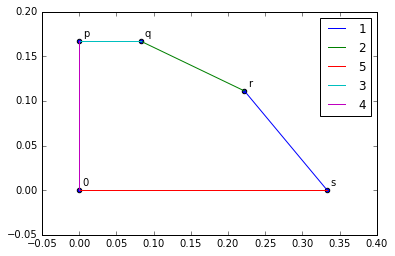

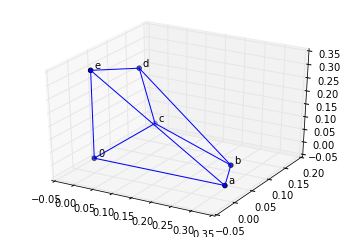

In [32]:
# Draw the pictures of polytopes
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D

A_H = np.empty((5, 2))
A_H[:3, :] = A
A_H[3:, :] = -np.eye(2)
b_H = np.ones(5)
b_H[3:] = 0

B_H = np.empty((5, 3))
B_H[:2, :] = B
B_H[2:, :] = -np.eye(3)
b2_H = np.ones(5)
b2_H[2:] = 0

# solve vertexs
vertex = []
constraint_ind = []
for ind in list(combinations(np.arange(0, 5), 2)):
    try:
        point = np.linalg.solve(A_H[ind, :], [b_H[z] for z in range(len(b_H)) if z in ind])
        if (A_H.dot(point) - b_H <= 0).all():
            vertex.append(point)
            constraint_ind.append(ind)
    except:
        None
        
plt.figure()
drawed = []
labels = ['1', '2', '5', '3', '4']
m = 0
for (i, v1) in enumerate(vertex):
    for (j, v2) in enumerate(vertex):
        constraint_common = set(constraint_ind[i]).intersection(set(constraint_ind[j]))
        if len(constraint_common) == 1:
            if constraint_common not in drawed:
                plt.plot([v1[0], v2[0]], [v1[1], v2[1]], label = labels[m])
                m += 1
                drawed.append(constraint_common)
plt.scatter([x for x,y in vertex], [y for x,y in vertex])

m = 0
pts = ['r', 's', 'q', 'p', '0']
for v in vertex:
    v = v + np.array([0.005, 0.005])
    plt.text(*v, pts[m])
    m += 1
plt.legend()

# solve vertexs
vertex = []
constraint_ind = []
for ind in list(combinations(np.arange(0, 5), 3)):
    try:
        point = np.linalg.solve(B_H[ind, :], [b2_H[z] for z in range(len(b_H)) if z in ind])
        if (B_H.dot(point) - b2_H <= 0).all():
            vertex.append(point)
            constraint_ind.append(ind)
    except:
        None

fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
drawed = []
for (i, v1) in enumerate(vertex):
    for (j, v2) in enumerate(vertex):
        constraint_common = set(constraint_ind[i]).intersection(set(constraint_ind[j]))
        if len(constraint_common) == 2:
            if constraint_common not in drawed:
                ax2.plot([v1[0], v2[0]], [v1[1], v2[1]], [v1[2], v2[2]], 'b')
                drawed.append(constraint_common)
                
pts = ['d', 'b', 'e', 'a', 'c', '0']
m = 0
for v in vertex:
    v = v + np.array([0.005, 0.005, 0.005])
    ax2.text(*v, pts[m])
    m += 1
ax2.scatter([x for x, y, z in vertex], [y for x, y, z in vertex], [z for x, y, z in vertex])

plt.show()

![Lemke_Howson_Fig1](https://raw.githubusercontent.com/shizejin/Lemke_Howson_notebook/master/Lemke_Howson_Fig1.png)

$((x, v), (y, u)) \in \bar{P} \times \bar{Q}$ is *completely labeled* if every $k \in M \cup N$ appears as a label of either $(x, v)$ or $(y, u)$.

In the context of best response polyhedron and labels, we can define Nash equilibrium as:  
* $(x, y) \in \Delta^{M} \times \Delta^{N}$ is a Nash equilibrium if and only if $((x, v), (y, u))$ with $u = \text{max}_i (A y)_i$ and $v = \text{max}_j (B x)_j$ is completely labeled.

The transformed best response polytope is a special case where $u = v = 1$, and we have

* $(x, y) \in P \times Q$, $(x, y) \neq (\mathbf{0}, \mathbf{0})$, is an ("un-normalized") Nash equilibirum if and only if $(x, y)$ is completely labeled.

If the game is nondegenerate, it is easy to know that in $P(Q)$, only vertices can have $m(n)$ labels.

Thus, the Nash equilibrium is confined in vertice pairs of two best response polyhedra. We can find a Nash equilibrium by enumerating vertice pairs to find completely labeled one. However, Lemke Howson algorithm provides a more efficient way that avoids enumerating.

### Lemke Howson algorithm for finding completely labeled vertice pairs

By all defintion, $(\mathbf{0}, \mathbf{0}) \in P \times Q$ is completely labeled. However, it is not a Nash equilibrium. We call it "artificial equilibrium". The Lemke Howson algorithm starts from $(\mathbf{0}, \mathbf{0})$, and moves the vertice by replacing the labels in $P$ and $Q$ in turn until it is completely labeled.

In detail, in the same example as before:

* $(\mathbf{0}, \mathbf{0})$ has labels {0, 1, 2}, {3, 4}
* $(\mathbf{0}, \mathbf{0}) \rightarrow (c, \mathbf{0})$ with label {0, 2, 4}, {3, 4}  
 Drop Label 1 in $P$ (Label to drop is arbitrarily chosen in the first step). Label 4 is picked up.
* $(c, \mathbf{0}) \rightarrow (c, p)$ with label {0, 2, 4}, {2, 3}  
 Drop Label 4 in $Q$ as it is label of both $x$ and $y$. Label 2 is picked up.
* $(c, p) \rightarrow (d, p)$ with label {0, 3, 4}, {2, 3}  
 Drop Label 2 in $P$ as it is label of both $x$ and $y$. Label 3 is picked up.
* ... ...
* Continue the procedure, until $(d, q)$ is achieved, which is completely labeled, and thus is a un-normalized Nash equilibrium.

### Complementary Pivoting

To implementing the dropping and picking up of labels, we introduce slack variables $s_3, s_4, r_0, r_1, r_2$:

$$
\begin{matrix}
3 x_0 & + 2 x_1 & + 3 x_2 & + s_3 & & = 1\\
2 x_0 & + 6 x_1 & + x_2 & & + s_4 & = 1 \\
\\
r_0 & & & + 3 y_3 & + 3 y_4 & = 1\\
 & r_1 & & + 2 y_3 & + 5 y_4 & = 1 \\
 & & r_2 & & + 6 y_4 & = 1 
\end{matrix}
$$

$x \geq \mathbf{0}, s \geq \mathbf{0}, r \geq \mathbf{0}, y \geq \mathbf{0}.$

A solution $(x, s, r, y)$ is completely labeled if and only if  
$$
x^\prime r = 0, \quad y^\prime s = 0
$$

Variables in $(x, s, r, y)$ are called *basic variables* if they are positive, and *nonbasic variables* if they are equal to $0$.

In this context, the geometric procedure showed above is equivalent to the algebraic procedure below, which we call *pivoting*.

During the process, what we need to record are the indices of basic variables, the coefficients of linear equations systems, and the values on the right-hand side. The latter two terms can be saved in arrays, which we denote as *tableaux*.

$$
tableau_1 = 
\begin{bmatrix}
3 & 2 & 3 & 1 & 0 & 1 \\
2 & 6 & 1 & 0 & 1 & 1 \\
\end{bmatrix}
$$

and 

$$
tableau_2 =
\begin{bmatrix}
1 & 0 & 0 & 3 & 3 & 1 \\
0 & 1 & 0 & 2 & 5 & 1 \\
0 & 0 & 1 & 0 & 6 & 1 
\end{bmatrix}
$$

respectively.

In detail, the algorithm is as follows:

1. Input two tableaus and lists of basic variables. As we start from $(\mathbf{0}, \mathbf{0})$, the initial basic variables are $\{s_3, s_4\}$ and $\{r_0, r_1, r_2\}$.
2. Start with pivoting in $P$. Initial pivot indice can be arbitrarily chosen. Because nonnegativity constraint, the basic variable to be replaced is decided by minimum ratio test. Then update the tableau and basis of $P$ by dropping and adding basic variables.
3. Do pivoting in $Q$. Check whether the newly dropped basic variable has the same indice with the first added basic variable by initial pivoting. If it is, then the solution is completely labeled, and a Nash equilibrium is found.
4. Repeat 3 and 4, until a Nash equilibirum is found. (Note that we will not be in infinite loop, as the existence of Nash equilibrium is guaranteed.)

### Code

We simply implement Lemke Howson algorithm using Python, with the same nondegenerate game.

First step, we create tableaus and indice lists of basic variables. Note that the indice list of basic variables is corresponding to the rows of tableau in order.

In [11]:
# Player 0
#create tableau of Player0
tableau0 = np.empty((n, m+n+1))
tableau0[:, :m] = B
tableau0[:, m:m+n] = np.identity(n)
tableau0[:, -1] = 1

# the indices of basic variables of Player0 at (0, 0)
basic_vars0 = np.arange(m, m+n)

# Player 1
#create tableau of Player1
tableau1 = np.empty((m, n+m+1))
tableau1[:, :m] = np.identity(m)
tableau1[:, m:m+n] = A
tableau1[:, -1] = 1

# the indices of basic variables of Player1 at (0, 0)
basic_vars1 = np.arange(0, m)

In [12]:
tableau0, tableau1

(array([[ 3.,  2.,  3.,  1.,  0.,  1.],
        [ 2.,  6.,  1.,  0.,  1.,  1.]]),
 array([[ 1.,  0.,  0.,  3.,  3.,  1.],
        [ 0.,  1.,  0.,  2.,  5.,  1.],
        [ 0.,  0.,  1.,  0.,  6.,  1.]]))

In [13]:
basic_vars0, basic_vars1

(array([3, 4]), array([0, 1, 2]))

Define `min_ratio_test` function for deciding leaving basic variable, when basic variable with pivot indice is entering.

In [14]:
def min_ratio_test(tableau, pivot):
    
    ind_nonpositive = tableau[:, pivot] <= 0
    # we suppress the "divide by zero" warning message
    with np.errstate(divide='ignore', invalid='ignore'):
        ratios = tableau[:, -1] / tableau[:, pivot]
    # leave out the pivots that have negative ratio
    ratios[ind_nonpositive] = np.inf
    # find the pivot with minimum ratio, under nonnegativity condition
    row_min = ratios.argmin()
    
    return row_min

`Pivoting` function is for updating the tableau after we decide entering and leaving basic variables. 

In [15]:
def pivoting(tableau, pivot, pivot_row):
    """
    Perform a pivoting step.
    
    Parameters
    ----------
    tableau : ndarray(float, ndim=2)
            The tableau to be updated
    
    pivot : scalar(int)
            The indice of entering basic variable
            
    pivot_row: scalar(int)
            The row indice of tableau chosen by minimum ratio test
            the corresponding basic variable is going to be dropped
    
    Returns
    -------
    tableau : ndarray(float, ndim=2)
            The updated tableau
            
    """
    # Row indices except pivot_row
    ind = np.ones(tableau.shape[0], dtype=bool)
    ind[pivot_row] = False
    
    # Store the values in the pivot column, except for row_min
    # Made 2-dim by np.newaxis
    multipliers = tableau[ind, pivot, np.newaxis]
    
    # Update the tableau
    tableau[pivot_row, :] /= tableau[pivot_row, pivot]
    tableau[ind, :] -= tableau[pivot_row, :] * multipliers
    
    return tableau

In [16]:
def lemke_howson_tbl(tableau0, tableau1, basic_vars0, basic_vars1, init_pivot):
    """
    Wrap the procedure of Lemke Howson algorithm.
    
    Parameters
    ----------
    tableau0 : ndarray(float, ndim=2)
            The tableau of Player 0
            
    tableau1 : ndarray(float, ndim=2)
            The tableau of Player 1
            
    basic_vars0 : list(int)
            The indice list of basic variables of tableau0
            
    basic_vars1 : list(int)
            The indice list of basic variables of tableau1
            
    init_pivot : scalar(int)
            The initial pivot indice, can be arbitrarily chosen
            
    Returns
    -------
    out : list(float, ndim=1)
        List of concatenated mixed action Nash equilibrium(un-normalized)
        of two Players
            
    """
    m, n = tableau1.shape[0], tableau0.shape[0]
    tableaux = (tableau0, tableau1)
    basic_vars = (basic_vars0, basic_vars1)
    init_player = int((basic_vars[0]==init_pivot).any())
    players = [init_player, 1 - init_player]

    pivot = init_pivot

    while True:
        for i in players:
            # Determine the leaving variable
            row_min = min_ratio_test(tableaux[i], pivot)
            
            # Pivoting step: modify tableau in place
            pivoting(tableaux[i], pivot, row_min)
            
            # Update the basic variables and the pivot
            basic_vars[i][row_min], pivot = pivot, basic_vars[i][row_min]
            
            if pivot == init_pivot:
                break
        else:
            continue
        break

    out_dtype = np.result_type(*tableaux)
    out = np.zeros(m+n, dtype=out_dtype)
    for i, (start, num) in enumerate(zip((0, m), (m, n))):
        ind = basic_vars[i] < start + num if i == 0 else start <= basic_vars[i]
        out[basic_vars[i][ind]] = tableaux[i][ind, -1]
        
    return out

In [17]:
init_pivot = 1
lemke_howson_tbl(tableau0, tableau1, basic_vars0, basic_vars1, init_pivot)

array([ 0.        ,  0.125     ,  0.25      ,  0.08333333,  0.16666667])

By the un-normalized NE returned by `lemke_howson_tbl`, we can calculate the normalized NE:

$$
x = (0, \frac{1}{3}, \frac{2}{3}) \quad y = (\frac{1}{3}, \frac{2}{3}) \\
u = \frac{8}{3}, \quad v = 4
$$

We can use the `lemke_howson` routine from `quantecon.py`, which wraps the procedure of creating tableaus and indice lists of basic variables, pivoting, and normalizing the found Nash equilibrium. 

In [18]:
import quantecon.game_theory as gt

# create normal form game
g = gt.NormalFormGame((gt.Player(A), gt.Player(B)))
# use lemke_howson with initial pivot being 1
gt.lemke_howson(g, init_pivot = 1)

(array([ 0.        ,  0.33333333,  0.66666667]),
 array([ 0.33333333,  0.66666667]))

# Degenerate Games

In a degenerate game, the minimum ratio test may have more than one minimizers. In this case, arbitrary tie breaking may lead to cycling, so that the algorithm falls into an infinite loop.

For example, we change the payoff matrixes for Player 0 and 1 to $C$ and $D$:

$$
C =
\begin{bmatrix}
3 & 3 \\
2 & 5 \\
0 & 6
\end{bmatrix},
\quad
D =
\begin{bmatrix}
3 & 2 & 3 \\
3 & 6 & 1 
\end{bmatrix}.
$$

As `numpy.argmin()` returns the first indice when there is a tie in 1-dimensional array, if we still use `lemke_howson_tbl` which utilize `min_ratio_test`, it may fail to find a Nash equilirbium properly.

We use lexico-minimum ratio test to replace minimum ratio test in a degenerate game for determining the leaving basic variable.

Note that the original system can be written as 

$$
D x + I s = \mathbf{1}
$$

where $x$ is the mixed action, and $s$ is the slack variable vector.

The lexico-minimum ratio test introduce $(\epsilon, \epsilon^1, \cdots, \epsilon^n)^\prime$ to the right hand:

$$
D x + I s = \mathbf{1} + (\epsilon, \epsilon^1, \cdots, \epsilon^n)^\prime
$$

After any number of pivoting steps, the system can be representd by pre-multiplying a inverse of a basic matrix $P$:

$$
P D x + P I s = P \mathbf{1} + P (\epsilon, \epsilon^1, \cdots, \epsilon^n)^\prime
$$

Write $p_{i0} + p_{i1} ε^1 + ··· + p_{in} ε^n$ for the ith entry of the vector in the right hand, and let $d_i$ be the ith row of the pivoting column.

The lexico-minimum ratio test break a tie by comparing the $p_{ik}$ and $p_{jk}$ in order:

* Choose the minimizers of $p_{i0} / d_{i}$.
* If more than one, among them choose the minimizers of $p_{i1} / d_{i}$.
* repeat this until there is only one minimizer

Note that when implementing this in code, the matrix $P$ is the same with the coefficient matrix of slack variables, and thus we do not need to extend tableau to record more information.

## code

In [19]:
# payoff matrixes of a degenerate game
C = np.array([[3, 3],
              [2, 5],
              [0 ,6]])
D = np.array([[3, 2, 3],
              [3, 6, 1]])

# Player 0
#create tableau of Player0
tableau0 = np.empty((n, m+n+1))
tableau0[:, :m] = D
tableau0[:, m:m+n] = np.identity(n)
tableau0[:, -1] = 1

# the indices of basic variables of Player0 at (0, 0)
basic_vars0 = np.arange(m, m+n)

# Player 1
#create tableau of Player1
tableau1 = np.empty((m, n+m+1))
tableau1[:, :m] = np.identity(m)
tableau1[:, m:m+n] = C
tableau1[:, -1] = 1

# the indices of basic variables of Player1 at (0, 0)
basic_vars1 = np.arange(0, m)

Note that the `lemke_howson` routine in `quantecon.py` always uses lexico-minimum ratio test, so there is no need to concern about the nondegenerate game when using it.

In [22]:
g = gt.NormalFormGame((gt.Player(C), gt.Player(D)))
gt.lemke_howson(g, init_pivot = 1)

(array([ 0.        ,  0.33333333,  0.66666667]),
 array([ 0.33333333,  0.66666667]))

# Simulation analysis of Lemke-Howson algorithm performance

Although Lemke-Howson algorithm already performs better than most of other algorithms for finding a Nash equilibrium, it could be even faster if we limit the number of pivoting steps for each initial pivot.

For a $n \times n$ two player normal form game, the heuristics implemention is in detail as follows:

* Set the maximum number of pivoting steps for each initial pivot.
* Starts from intial pivot being $0$, if no Nash equilibiurm is found within maximum number of pivoting steps, change to next intial pivot 1.
* Repeat this, until went through all possible $2 n$ initial pivots.
* If no Nash equilibrium is achieved, choose a initial pivot arbitrarily, and do pivoting step unlimitedly until Nash equilibrium is found.

One can refer to [Bruno Codenotti, Stefano De Rossi, Marino Pagan (2008)](https://arxiv.org/abs/0811.3247) for more details. *AND PUT THE LINK OF ANOTHER NOTEBOOK HERE!!*

## code

If we set the `full_output` as `True` in `lemke_howson`, the details of pivoting process would be reported.

Use the example of degenerate game.

In [21]:
lemke_howson(g, init_pivot=1, full_output=True)

((array([ 0.        ,  0.33333333,  0.66666667]),
  array([ 0.33333333,  0.66666667])),
          NE: (array([ 0.        ,  0.33333333,  0.66666667]), array([ 0.33333333,  0.66666667]))
  converged: True
 init_pivot: 1
   max_iter: 1000000
   num_iter: 4)

"converged" shows whether a Nash equilibrium is found or not, and "num_iter" shows the number of pivoting steps.

"max_iter" is the maximum number of pivoting steps for each intial pivot, whose default is set as 1000000. We can change it by setting the argument `capping`. Knowing these, we can use basic Lemke-Howson algorithm to implement an experimental analysis of the heuristics.

In [27]:
def Novel_Heuristics(n, num_instance, capping=10**6, seed=0):
    """
    Implementing the novel heuristics proposed by Codenotti et al (2008).
    
    Parameters
    ----------
    n : scalar(int)
        The size of bimatrix game, which is the number of strategies 
        for each player.
    
    num_instance : scalar(int)
        The number of simulation instances to run.
            
    capping : scalar(int), optional(default=10**6)
        The maximum number of pivoting steps.
        
    seed : scalar(int), optional(default=0)
        Seed for generating random variables.
    
    Returns
    -------
    NEs : list(array, ndim=1)
        The list of NEs found in each simulation.
    steps : list(int, ndim=1)
        The list of number of pivoting steps of Lemke Howson algorithm 
        implemented in each simulation.
            
    """
    NEs = []
    steps = []
    np.random.seed(seed)
    
    for i in range(num_instance):
        num_step = 0
        # create random n by n bimatrix game
        A, B = [np.random.rand(n, n) for i in range(2)]
        g = gt.NormalFormGame((gt.Player(A), gt.Player(B)))
        for j in range(2*n-1):
            res = gt.lemke_howson(g, init_pivot=j, full_output=True, max_iter=capping)[1]
            num_iter = res['num_iter']
            status = res['converged']
            num_step += num_iter
            if status == True:
                steps.append(num_step)
                NEs.append(res['NE'])
                break
        if status == False:
            num_step += gt.lemke_howson(g, init_pivot=2*n-1, full_output=True)[1]['num_iter']
            steps.append(num_step)
            NE = res['NE']
                
    return steps, NEs

Set the size of bimatrix game $n = 100$, and do $10000$ times simulation. As Codenotti et al (2008) suggests, we set the maximum number of pivoting steps to be 10.

In [28]:
simu1 = np.array(Novel_Heuristics(100, 10000, capping = 10)[0])
simu2 = np.array(Novel_Heuristics(100, 10000)[0])

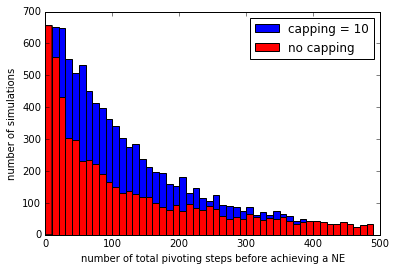

In [29]:
plt.figure()
for (step, (c, label)) in zip([simu1, simu2], [('b', 'capping = 10'), ('r', 'no capping')]):
    plt.hist(step, bins=np.arange(0, 500, 10), color=c, label=label)
plt.xlabel('number of total pivoting steps before achieving a NE')
plt.ylabel('number of simulations')
plt.legend()
plt.show()

As we can see, the number of total pivoting steps is significantly lower for Lemke Howson algorithm with capping being 10, which means it performs better for finding a Nash equilibrium.